# Soft Actor Criticを構築する

In [24]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import torch
import gym
from gym.wrappers import RecordVideo
from agents import SoftActorCriticModel
from memories import ReplayMemory

In [2]:
%load_ext autoreload
%autoreload 2

## パラメータの設定

In [3]:
gym_game_name = 'Pendulum-v1'

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
model_dir_path = Path('model')
if not model_dir_path.exists():
    model_dir_path.mkdir(parents=True)
    
result_dir_path = Path('result')
if not result_dir_path.exists():
    result_dir_path.mkdir(parents=True)

In [5]:
seed = 123456
torch.manual_seed(seed)
np.random.seed(seed)

## ゲーム環境の構築

In [13]:
env = gym.make(gym_game_name)
env.action_space.seed(seed)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:97: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  logger.warn(


[123456]

## Soft Actor Criticの構築

In [18]:
args = {
    'gamma': 0.99,
    'tau': 0.005,
    'alpha': 0.2,
    'seed': 123456,
    'batch_size': 256,
    'hidden_size': 256,
    'start_steps': 1000,
    'updates_per_step': 1,
    'target_update_interval': 1,
    'memory_size': 100000,
    'epochs': 100,
    'eval_interval': 10
}

In [22]:
agent = SoftActorCriticModel(
    state_dim=env.observation_space.shape[0], action_dim=env.action_space.shape[0],
    action_scale=env.action_space.high[0], args=args, device=device
)
memory = ReplayMemory(args['memory_size'])

episode_reward_list = []
eval_reward_list = []

n_steps = 0
n_update = 0
for i_episode in range(1, args['epochs'] + 1):

    episode_reward = 0
    done = False
    state = env.reset()

    while not done:
        
        if args['start_steps'] > n_steps:
            action = env.action_space.sample()
        else:
            action = agent.select_action(state)

        if len(memory) > args['batch_size']:
            agent.update_parameters(memory, args['batch_size'], n_update)
            n_update += 1

        next_state, reward, done, _ = env.step(action)
        n_steps += 1
        episode_reward += reward

        memory.push(state=state, action=action, reward=reward, next_state=next_state, mask=float(not done))

        state = next_state

    episode_reward_list.append(episode_reward)

    if i_episode % args['eval_interval'] == 0:
        avg_reward = 0.
        for _  in range(args['eval_interval']):
            state = env.reset()
            episode_reward = 0
            done = False
            while not done:
                with torch.no_grad():
                    action = agent.select_action(state, evaluate=True)
                next_state, reward, done, _ = env.step(action)
                episode_reward += reward
                state = next_state
            avg_reward += episode_reward
        avg_reward /= args['eval_interval']
        eval_reward_list.append(avg_reward)

        print("Episode: {}, Eval Avg. Reward: {:.0f}".format(i_episode, avg_reward))

print('Game Done !! Max Reward: {:.2f}'.format(np.max(eval_reward_list)))

torch.save(agent.actor_net.to('cpu').state_dict(), model_dir_path.joinpath(f'{gym_game_name}_sac_actor.pth'))

Episode: 10, Eval Avg. Reward: -1146
Episode: 20, Eval Avg. Reward: -419
Episode: 30, Eval Avg. Reward: -202
Episode: 40, Eval Avg. Reward: -233
Episode: 50, Eval Avg. Reward: -130
Episode: 60, Eval Avg. Reward: -163
Episode: 70, Eval Avg. Reward: -110
Episode: 80, Eval Avg. Reward: -109
Episode: 90, Eval Avg. Reward: -166
Episode: 100, Eval Avg. Reward: -146
Game Done !! Max Reward: -108.58


## 学習時の評価報酬の可視化

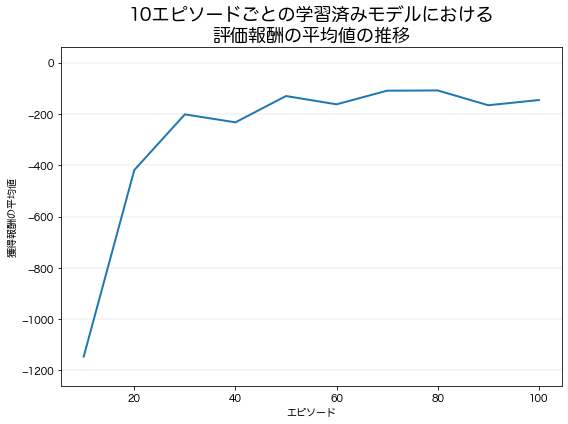

In [25]:
plt.figure(figsize=(8, 6), facecolor='white')
g = sns.lineplot(
    data=pd.DataFrame({
        'episode': range(args['eval_interval'], args['eval_interval'] * (len(eval_reward_list) + 1), args['eval_interval']),
        'reward': eval_reward_list
    }),
    x='episode', y='reward', lw=2
)
plt.title('{}エピソードごとの学習済みモデルにおける\n評価報酬の平均値の推移'.format(args['eval_interval']), fontsize=18, weight='bold')
plt.xlabel('エピソード')
plt.ylabel('獲得報酬の平均値')
for tick in plt.yticks()[0]:
    plt.axhline(tick, color='grey', alpha=0.1)
plt.tight_layout()
plt.savefig(result_dir_path.joinpath('{}_sac_eval_reward_{}.png'.format(gym_game_name, args['eval_interval'])), dpi=500)

## 学習済みモデルの検証

In [26]:
state = env.reset()
episode_reward = 0
done = False
while not done:
    with torch.no_grad():
        action = agent.select_action(state, evaluate=True)
    next_state, reward, done, _ = env.step(action)
    env.render()
    episode_reward += reward
    state = next_state
print('Reward: {:.2f}'.format(episode_reward))

2022-06-23 14:46:03.424 Python[18449:32681283] ApplePersistenceIgnoreState: Existing state will not be touched. New state will be written to /var/folders/0z/jfdrd7z91lvfm8jskr77zkd40000gn/T/org.python.python.savedState


Reward: -123.79


In [27]:
result = []
for experiment_name in ['agent', 'random']:
    for i in tqdm(range(100)):

        state = env.reset()
        episode_reward = 0
        done = False
        while not done:
            if experiment_name == 'agent':
                with torch.no_grad():
                    action = agent.select_action(state, evaluate=True)
            else:
                action = env.action_space.sample()
            next_state, reward, done, _ = env.step(action)
            episode_reward += reward
            state = next_state
        result.append([experiment_name, i, episode_reward])
result = pd.DataFrame(result, columns=['experiment_name', 'i', 'reward'])

100%|██████████| 100/100 [00:01<00:00, 55.99it/s]


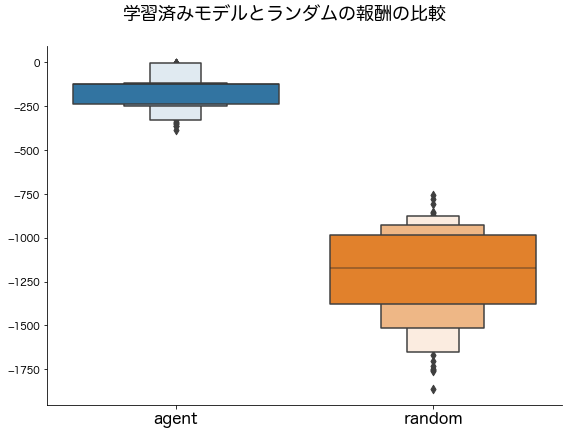

In [28]:
g = sns.catplot(data=result, x='experiment_name', y='reward', kind='boxen')
g.fig.suptitle('学習済みモデルとランダムの報酬の比較', fontsize=18, weight='bold', y=1.0)
g.fig.set_figwidth(8)
g.fig.set_figheight(6)
g.fig.set_facecolor('white')
g.set_xlabels('')
g.set_ylabels('')
g.set_xticklabels(fontsize=16)
g.tight_layout()
g.savefig(result_dir_path.joinpath(f'{gym_game_name}_sac_reward_agent_vs_random.png'), dpi=500)

## 学習済みモデルのプレイを動画で保存し、GIF化する

In [29]:
from moviepy.editor import *
import warnings
warnings.filterwarnings('ignore')

In [30]:
video_dir_path = Path('video')
if not video_dir_path.exists():
    video_dir_path.mkdir(parents=True)

In [31]:
env = RecordVideo(
    gym.make(gym_game_name), video_folder=video_dir_path.__str__(), name_prefix=gym_game_name
)

state = env.reset()
episode_reward = 0
done = False
while not done:
    with torch.no_grad():
        action = agent.select_action(state, evaluate=True)
    next_state, reward, done, _ = env.step(action)
    env.render()
    episode_reward += reward
    state = next_state
print('Reward: {:.2f}'.format(episode_reward))
env.close()

Reward: -123.18


In [32]:
input_file_path = video_dir_path.joinpath(f'{gym_game_name}-episode-0.mp4')
output_file_path = video_dir_path.joinpath(f'{gym_game_name}-actor-critic.gif')
 
clip = VideoFileClip(input_file_path.__str__())
clip = clip.resize(width=600)
clip.write_gif(output_file_path.__str__(), fps=14)
clip.close()

MoviePy - Building file video/Pendulum-v1-actor-critic.gif with imageio.
